<a href="https://colab.research.google.com/github/Marouene-Oueslati/Notebooks_DL-AI-TensorFlow-Developer-Professional-Certificate/blob/master/S%2BP_Week_4_Exercise_Question.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
import tensorflow as tf
print(tf.__version__)

2.4.1


In [3]:
from tensorflow import keras
from tensorflow.keras import layers

In [4]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [5]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv \
    -O /tmp/daily-min-temperatures.csv

--2021-03-18 16:43:04--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67921 (66K) [text/plain]
Saving to: ‘/tmp/daily-min-temperatures.csv’

/tmp/daily-min-temp 100%[===================>]  66.33K  --.-KB/s    in 0.001s  

2021-03-18 16:43:04 (78.5 MB/s) - ‘/tmp/daily-min-temperatures.csv’ saved [67921/67921]



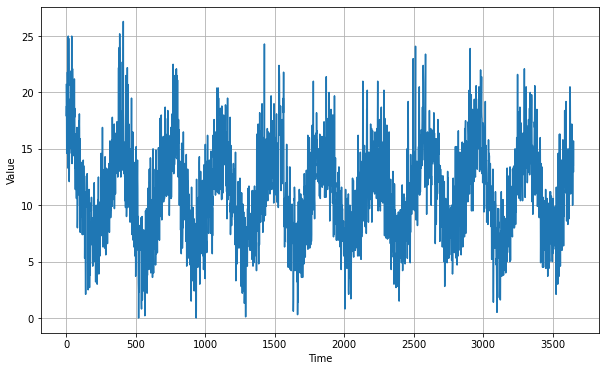

In [6]:
import csv
time_step = []
temps = []

with open('/tmp/daily-min-temperatures.csv') as csvfile:
# YOUR CODE HERE. READ TEMPERATURES INTO TEMPS
# HAVE TIME STEPS BE A SIMPLE ARRAY OF 1, 2, 3, 4 etc
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  sample = 0
  for row in reader:
    
    temps.append(float(row[1]))
    sample += 1
    time_step.append(sample)

series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [7]:
split_time = 2500
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:-1]
x_valid = series[split_time:-1]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000


In [8]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)


In [9]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [10]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential(name="my_model")
model.add(layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]))
model.add(layers.LSTM(64, return_sequences=True))
model.add(layers.LSTM(64, return_sequences=True))
model.add(layers.Dense(30, activation="relu"))
model.add(layers.Dense(10, activation="relu"))
model.add(layers.Dense(1))
model.add(layers.Lambda(lambda x: x * 400))

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(2500,)
Epoch 1/100
10/10 [==============================] - 34s 32ms/step - loss: 31.0287 - mae: 31.5267
Epoch 2/100
10/10 [==============================] - 0s 26ms/step - loss: 30.7697 - mae: 31.2675
Epoch 3/100
10/10 [==============================] - 0s 28ms/step - loss: 29.9371 - mae: 30.4346
Epoch 4/100
10/10 [==============================] - 0s 31ms/step - loss: 28.6752 - mae: 29.1725
Epoch 5/100
10/10 [==============================] - 0s 29ms/step - loss: 27.2988 - mae: 27.7959
Epoch 6/100
10/10 [==============================] - 0s 29ms/step - loss: 25.7600 - mae: 26.2569
Epoch 7/100
10/10 [==============================] - 0s 30ms/step - loss: 24.0420 - mae: 24.5383
Epoch 8/100
10/10 [==============================] - 0s 27ms/step - loss: 21.3711 - mae: 21.8673
Epoch 9/100
10/10 [==============================] - 0s 27ms/step - loss: 18.2363 - mae: 18.7316
Epoch 10/100
10/10 [====

(1e-08, 0.0001, 0.0, 60.0)

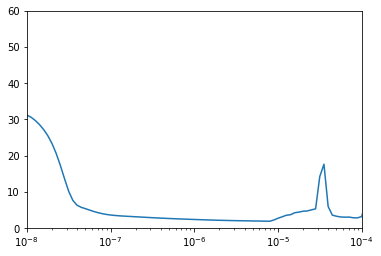

In [36]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [11]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=9e-6, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=150)
                                    
# EXPECTED OUTPUT SHOULD SEE AN MAE OF <2 WITHIN ABOUT 30 EPOCHS

Epoch 1/150
25/25 [==============================] - 3s 33ms/step - loss: 18.2299 - mae: 18.7240
Epoch 2/150
25/25 [==============================] - 0s 14ms/step - loss: 3.4480 - mae: 3.9219
Epoch 3/150
25/25 [==============================] - 0s 14ms/step - loss: 2.2287 - mae: 2.6875
Epoch 4/150
25/25 [==============================] - 0s 15ms/step - loss: 2.0530 - mae: 2.5093
Epoch 5/150
25/25 [==============================] - 0s 14ms/step - loss: 1.9080 - mae: 2.3625
Epoch 6/150
25/25 [==============================] - 0s 16ms/step - loss: 1.8703 - mae: 2.3240
Epoch 7/150
25/25 [==============================] - 0s 15ms/step - loss: 1.8398 - mae: 2.2929
Epoch 8/150
25/25 [==============================] - 1s 17ms/step - loss: 1.8107 - mae: 2.2627
Epoch 9/150
25/25 [==============================] - 0s 15ms/step - loss: 1.7998 - mae: 2.2518
Epoch 10/150
25/25 [==============================] - 0s 14ms/step - loss: 1.7681 - mae: 2.2188
Epoch 11/150
25/25 [===========================

In [17]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size+1:-1, -1, 0]

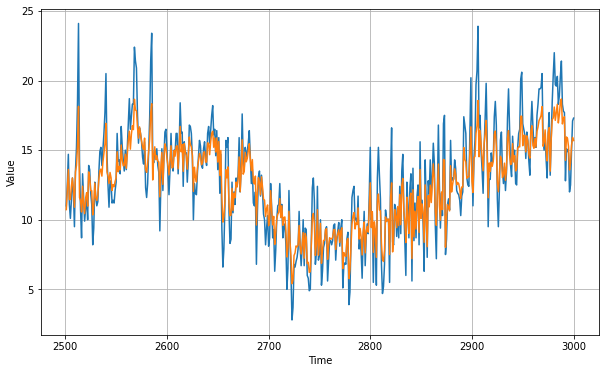

In [20]:
plt.figure(figsize=(10, 6))
plot_series(time_valid[0:500], x_valid[0:500])
plot_series(time_valid[0:500], rnn_forecast[0:500])

# EXPECTED OUTPUT. PLOT SHOULD SHOW PROJECTIONS FOLLOWING ORIGINAL DATA CLOSELY

In [21]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

# EXPECTED OUTPUT MAE < 2 -- I GOT 1.789626

0.988929

In [22]:
print(rnn_forecast)
# EXPECTED OUTPUT -- ARRAY OF VALUES IN THE LOW TEENS

[10.729077  12.1279955 13.6115265 ... 13.675584  13.875036  15.039748 ]
